# Supplemental Material for EMA Manuscript

Machine learning models for temporally precise lapse prediction in alcohol use disorder

Kendra Wyant, Sarah J. Sant’Ana, Gaylen E. Fronk, John J. Curtin  
January 3, 2025

In [ ]:
# settings
options(knitr.kable.NA = '')
knitr::opts_chunk$set(out.extra = "")
options(scipen = 999) #removes scientific notation


In [ ]:
library(knitr)
# library(yardstick) # for roc_curve and pr_curve
library(kableExtra)
library(janitor)



Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::group_rows() masks kableExtra::group_rows()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.7      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()   masks purrr::discard()
✖ dplyr::filter()     masks stats::filter()
✖ recipes::fixed()    masks stringr::fixed()
✖ dplyr::group_rows() masks kableExtra::group_rows()
✖ dplyr::lag()        masks stats::lag()
✖ yardstick::spec()   masks readr::spec()
✖ recipes::step()     masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/


Attaching package: 'cowplot'

The following object is masked from 'package:lubridate':

    stamp

The following object is masked from 'package:patchwork':

    align_plots

In [ ]:
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

In [ ]:
# Table data
disposition <- read_csv(file.path(path_processed, "disposition.csv"), 
                        col_types = "ccDDcccccccccc")
screen <- read_csv(file.path(path_shared, "screen.csv"), 
                   col_types = cols()) |>
  filter(subid %in% subset(disposition, analysis == "yes")$subid)

lapses <- read_csv(file.path(path_shared, "lapses.csv"), col_types = cols()) |>
  filter(exclude == FALSE)

# Predictions data
preds_week<- read_rds(file.path(path_models, "outer_preds_1week_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)
preds_day<- read_rds(file.path(path_models, "outer_preds_1day_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)
preds_hour<- read_rds(file.path(path_models, "outer_preds_1hour_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)

auc_week <- read_rds(file.path(path_models, "outer_metrics_1week_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))
auc_day <- read_rds(file.path(path_models, "outer_metrics_1day_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))
auc_hour <- read_rds(file.path(path_models, "outer_metrics_1hour_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))

auc_week_baseline <- read_rds(file.path(path_models, "outer_metrics_1week_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc")) 

auc_day_baseline <- read_rds(file.path(path_models, "outer_metrics_1day_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc")) 

auc_hour_baseline <- read_rds(file.path(path_models, "outer_metrics_1hour_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc"))

# posterior probabilities
pp <- read_rds(file.path(path_models, "posteriors_all_0_v5_nested.rds"))
pp_baseline <- read_rds(file.path(path_models, "posteriors_all_0_v3_nested_baseline.rds"))

# roc overall
roc_week_full <- preds_week |> 
  roc_curve(prob, truth = label)

roc_day_full <- preds_day |> 
  roc_curve(prob, truth = label)

roc_hour_full <- preds_hour |> 
  roc_curve(prob, truth = label)

# rocs per fold
roc_week <- preds_week |> 
  nest(.by = outer_split_num, .key = "preds") |> 
  mutate(roc = map(preds, \(preds) roc_curve(preds, prob,
                                             truth = label))) |> 
  mutate(model = "week")

roc_day <- preds_day |> 
  nest(.by = outer_split_num, .key = "preds") |> 
  mutate(roc = map(preds, \(preds) roc_curve(preds, prob,
                                             truth = label))) |> 
  mutate(model = "day")

roc_hour <- preds_hour |> 
  nest(.by = outer_split_num, .key = "preds") |> 
  mutate(roc = map(preds, \(preds) roc_curve(preds, prob,
                                             truth = label))) |> 
  mutate(model = "week")


# PR curves
pr_week <- preds_week |> 
  pr_curve(prob, truth = label) |>  
  mutate(model = "1week")

pr_day <- preds_day |> 
  pr_curve(prob, truth = label) |> 
  mutate(model = "1day")

pr_hour <- preds_hour|> 
  pr_curve(prob, truth = label) |> 
  mutate(model = "1hour")

pr_all <- pr_week |> 
  bind_rows(pr_day) |> 
  bind_rows(pr_hour)


# lapse labels
labels_week <- read_csv(file.path(path_processed, "labels_1week.csv"), col_types = cols())
labels_day <- read_csv(file.path(path_processed, "labels_1day.csv"), col_types = cols())
labels_hour <- read_csv(file.path(path_processed, "labels_1hour.csv"), col_types = cols())

# ema data
ema_m <- read_csv(file.path(path_shared, "ema_morning.csv"), col_types = cols()) |> 
  mutate(read_csv = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))
ema_l <- read_csv(file.path(path_shared, "ema_later.csv"), col_types = cols()) |> 
  mutate(start_date = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))


# features for missing data calculations
d_hour <- read_csv(file.path(path_processed, "features_1hour_0_v5.csv.xz"), col_types = cols())

d_day <- read_csv(file.path(path_processed, "features_1day_0_v5.csv.xz"), col_types = cols())

d_week <- read_csv(file.path(path_processed, "features_1week_0_v5.csv.xz"), col_types = cols())


## Supplemental Figures

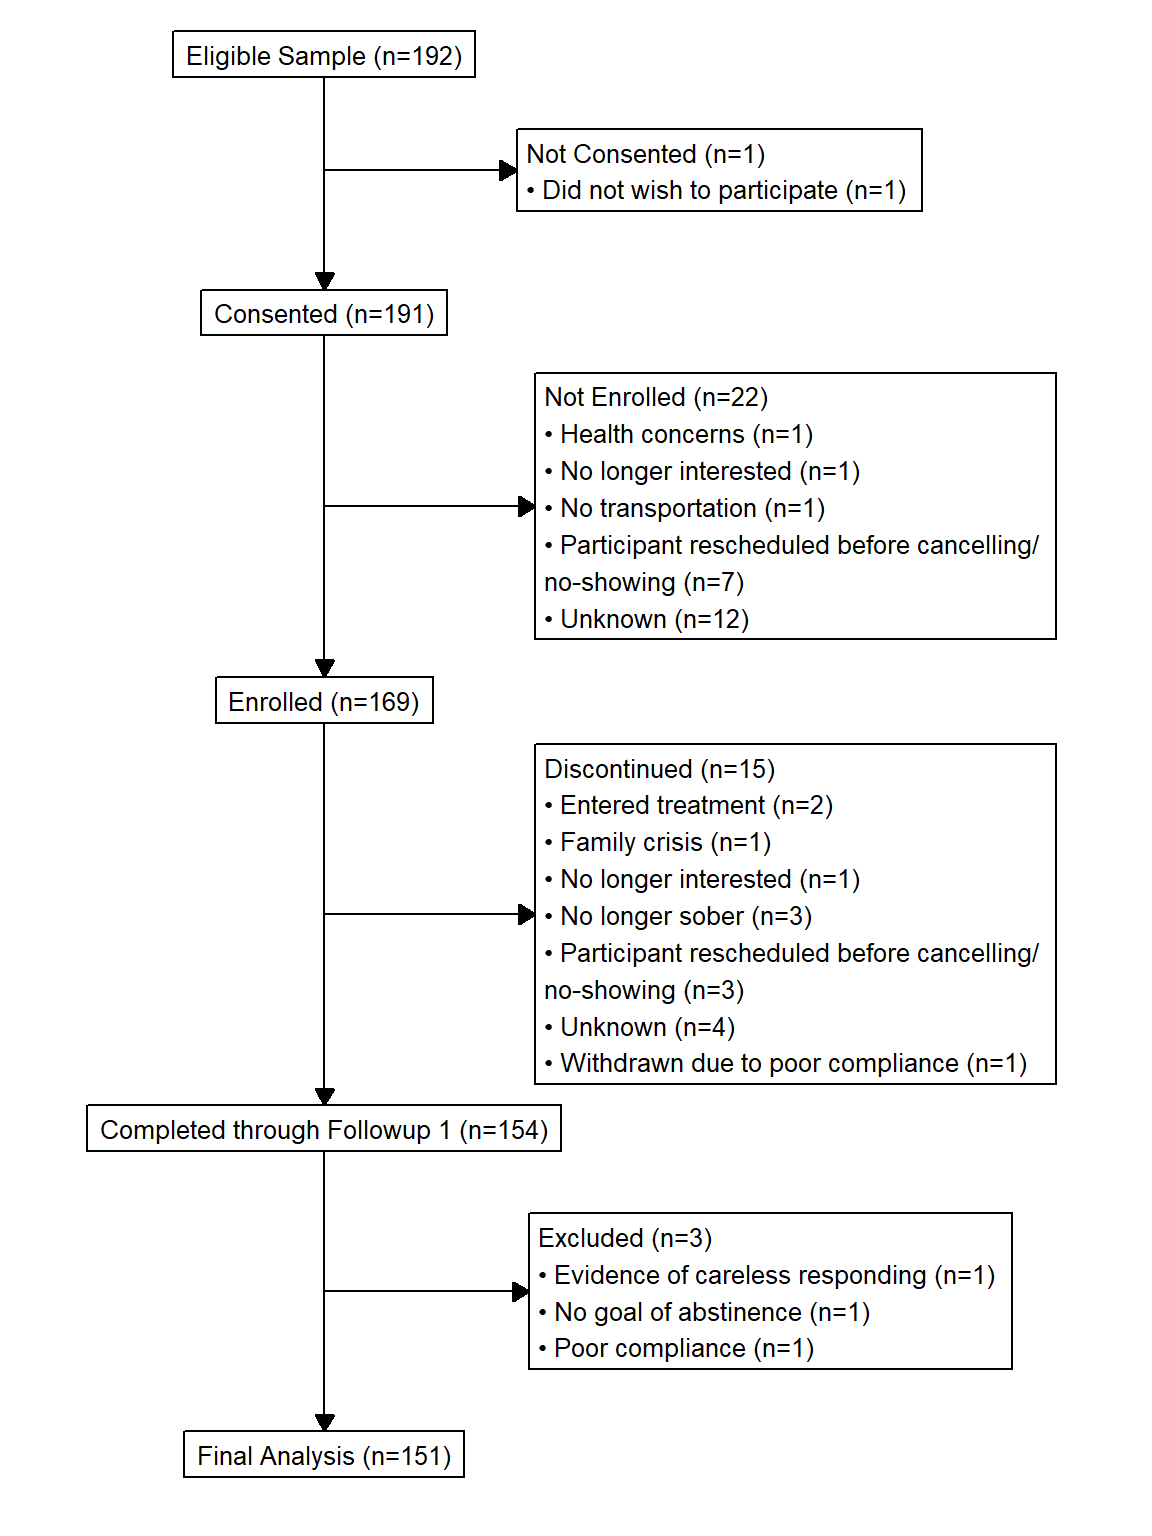

In [ ]:

consort_plot(data = disposition,
             orders = c(eligible = "Eligible Sample",
                        consented_reason = "Not Consented",
                        consented = "Consented",
                        enrolled_reason = "Not Enrolled",
                        enrolled = "Enrolled",
                        completed_followup_reason = "Discontinued",
                        completed_followup = "Completed through Followup 1",
                        analysis_reason = "Excluded",
                        analysis = "Final Analysis"),
             side_box = c("consented_reason", 
                          "enrolled_reason", 
                          "completed_followup_reason",
                          "analysis_reason"),
             cex = .8,
             text_width = 45)


In [ ]:
ana_sample <- disposition |> 
  filter(analysis == "yes")

ema <- ema_m |> 
  select(subid, start_date) |> 
  full_join(ema_l |> select(subid, start_date), by = c("subid", "start_date")) |> 
  mutate(start_date = date(start_date),
         subid = as.numeric(subid)) |> 
  filter(subid %in% ana_sample$subid)

# function to map over
get_study_days <- function(the_subid, dates) {
  start_study <- dates |> filter(subid == the_subid) |> pull(start_study)
  end_study <- dates |> filter(subid == the_subid) |> pull(end_study)
  study_days <- tibble(subid = the_subid, study_day = seq(start_study, end_study - days(1), by = "day")) 
  return(study_days)
}

study_dates <- ana_sample$subid |> 
  map_dfr(~get_study_days(.x, disposition |> 
                            select(subid, start_study, end_study)))

# count EMAs per day
ema_count_4x <- ema |>  
  count(subid, start_date) |>
  mutate(n = if_else(n > 4, 4, as.numeric(n)))

# left join with study dates
ema_study_dates <- study_dates |>
  left_join(ema_count_4x |> 
              mutate(subid = as.character(subid)), by = c("subid", "study_day" = "start_date")) |> 
  mutate(n = if_else(is.na(n), 0, n)) |> 
  mutate(n_prompts = 4)

# slice into 7 day bins
ema_study_weeks <- ema_study_dates |> 
  group_by(subid) |> 
  slice(1:7) |> 
  mutate(week = 1) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(8:14) |> 
    mutate(week = 2)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(15:21) |> 
    mutate(week = 3)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(22:28) |> 
    mutate(week = 4)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(29:35) |> 
    mutate(week = 5)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(36:42) |> 
    mutate(week = 6)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(43:49) |> 
    mutate(week = 7)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(50:56) |> 
    mutate(week = 8)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(57:63) |> 
    mutate(week = 9)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(64:70) |> 
    mutate(week = 10)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(71:77) |> 
    mutate(week = 11)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(78:84) |> 
    mutate(week = 12)) |> 
  ungroup()

ema_week_compliance_4x <- ema_study_weeks |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()

ema_week_compliance_1x <- ema_study_weeks |>
  mutate(n = if_else(n > 1, 1, n),
         n_prompts = 1) |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()


In [ ]:
week_compliance_all <- ema_week_compliance_4x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "4x Daily") |> 
  bind_rows(ema_week_compliance_1x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "1x Daily")) 


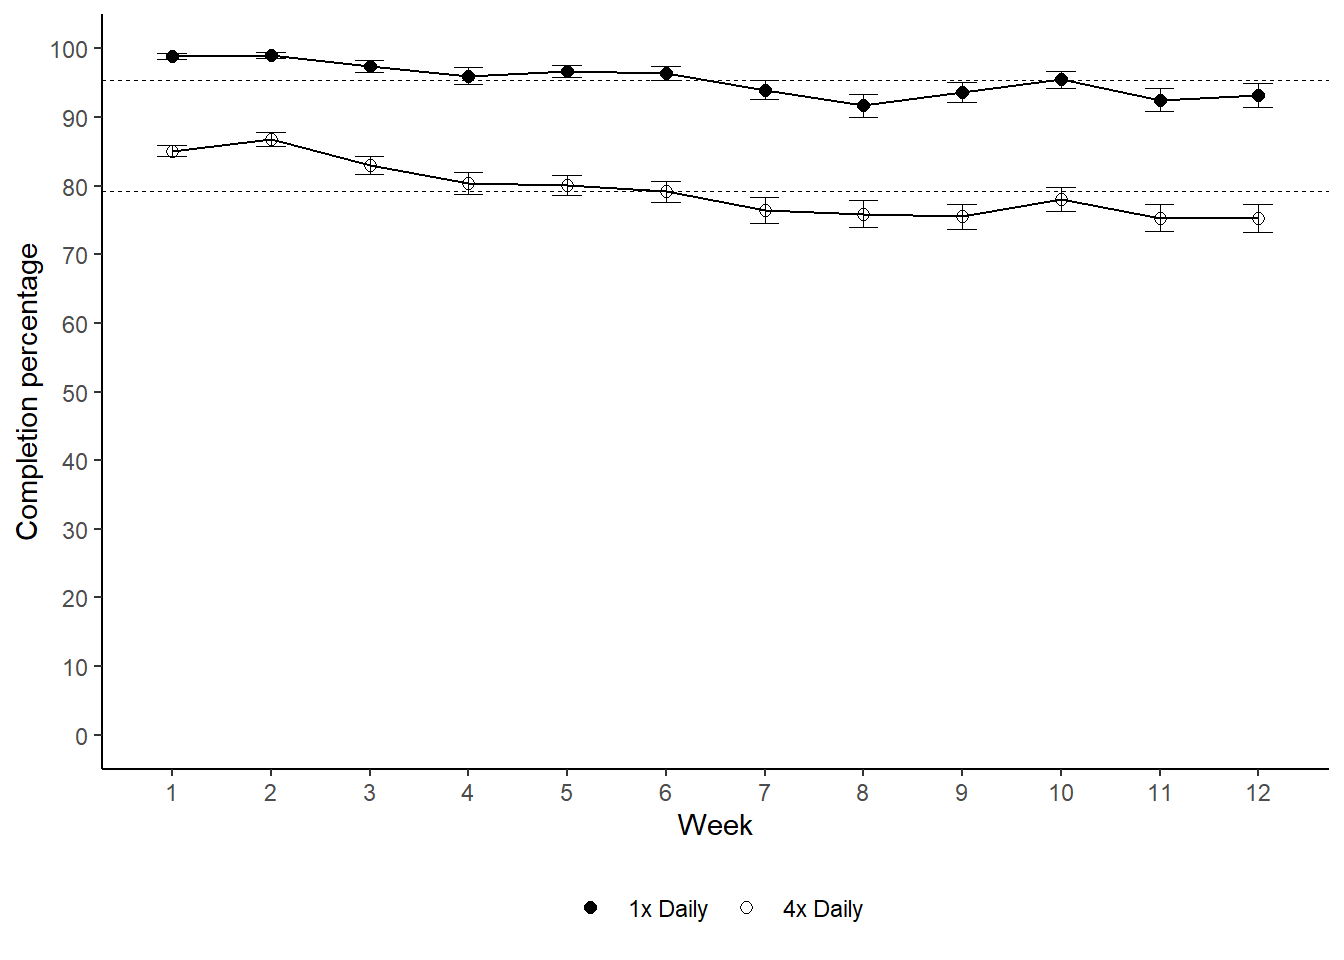

In [ ]:
#| fig-cap:
#|   - "EMA completion by week. The plot depicts completion percentages over time (by week) across the study period for 1x (closed circles) and 4x (open circles) daily EMA. Dashed lines represent mean EMA completion over entire study period for 1x and 4x daily EMA. Error bars represent the standard error for each completion percentage by week."

week_compliance_all |> 
  mutate(signal = factor(signal, levels = c("1x Daily", "4x Daily"))) |> 
  group_by(week, signal) |> 
  ggplot(aes(x = week, y = mean_compliance, group = signal, shape = signal)) +
  geom_point(size = 2) +
  geom_line() +
  geom_errorbar(aes(ymin = mean_compliance - se, ymax = mean_compliance + se), 
                width = .3, linewidth = .3) +
  theme_classic() +
  scale_shape_manual(values = c(19, 1, 17)) +
  scale_x_continuous(name = "Week", 
                     breaks = seq(1, 12, 1)) +
  scale_y_continuous(name = "Completion percentage", 
                     breaks = seq(0, 100, 10), 
                     limits = c(0, 100)) +
  geom_hline(aes(yintercept = mean_compliance), week_compliance_all |> 
               group_by(signal) |> 
               summarize(mean_compliance = mean(mean_compliance)),
             linetype = "dashed", linewidth = .3) +
  theme(legend.title = element_blank(),
        legend.position = "bottom")


In [ ]:
j_thres_week <- roc_week_full |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
#  print() |> 
  pull(.threshold)

j_thres_day <- roc_day_full |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
#  print() |> 
  pull(.threshold)

j_thres_hour <- roc_hour_full |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
#  print() |> 
  pull(.threshold)


In [ ]:
fig_preds_week_lapse <- preds_week |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Week") |> 
  filter(truth == "Lapse") |> 
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#F8766D", col = "black", alpha = .4) +
   facet_wrap(~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_week, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab("Count")

fig_preds_week_nolapse <- preds_week |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Week") |> 
  filter(truth == "No lapse") |> 
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#F8766D", col = "black", alpha = .4) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_week, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab("Count")


fig_preds_day_lapse <- preds_day |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Day") |> 
  filter(truth == "Lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#00BA38", col = "black", alpha = .4) +
   facet_wrap(~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_day, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab(NULL)

fig_preds_day_nolapse <- preds_day |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Day") |> 
  filter(truth == "No lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#00BA38", col = "black", alpha = .4) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_day, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab(NULL)

fig_preds_hour_lapse <- preds_hour |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Hour") |> 
  filter(truth == "Lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#619CFF", col = "black", alpha = .4) +
   facet_grid(truth~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_hour, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab(NULL)

fig_preds_hour_nolapse <- preds_hour |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Hour") |> 
  filter(truth == "No lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#619CFF", col = "black", alpha = .4) +
   facet_wrap(~truth, strip.position = "right") +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_hour, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab(NULL)


fig_week <- plot_grid(fig_preds_week_lapse, fig_preds_week_nolapse, ncol = 1, align = "v")
fig_day <- plot_grid(fig_preds_day_lapse, fig_preds_day_nolapse, ncol = 1, align = "v")
fig_hour <- plot_grid(fig_preds_hour_lapse, fig_preds_hour_nolapse, ncol = 1, align = "v")


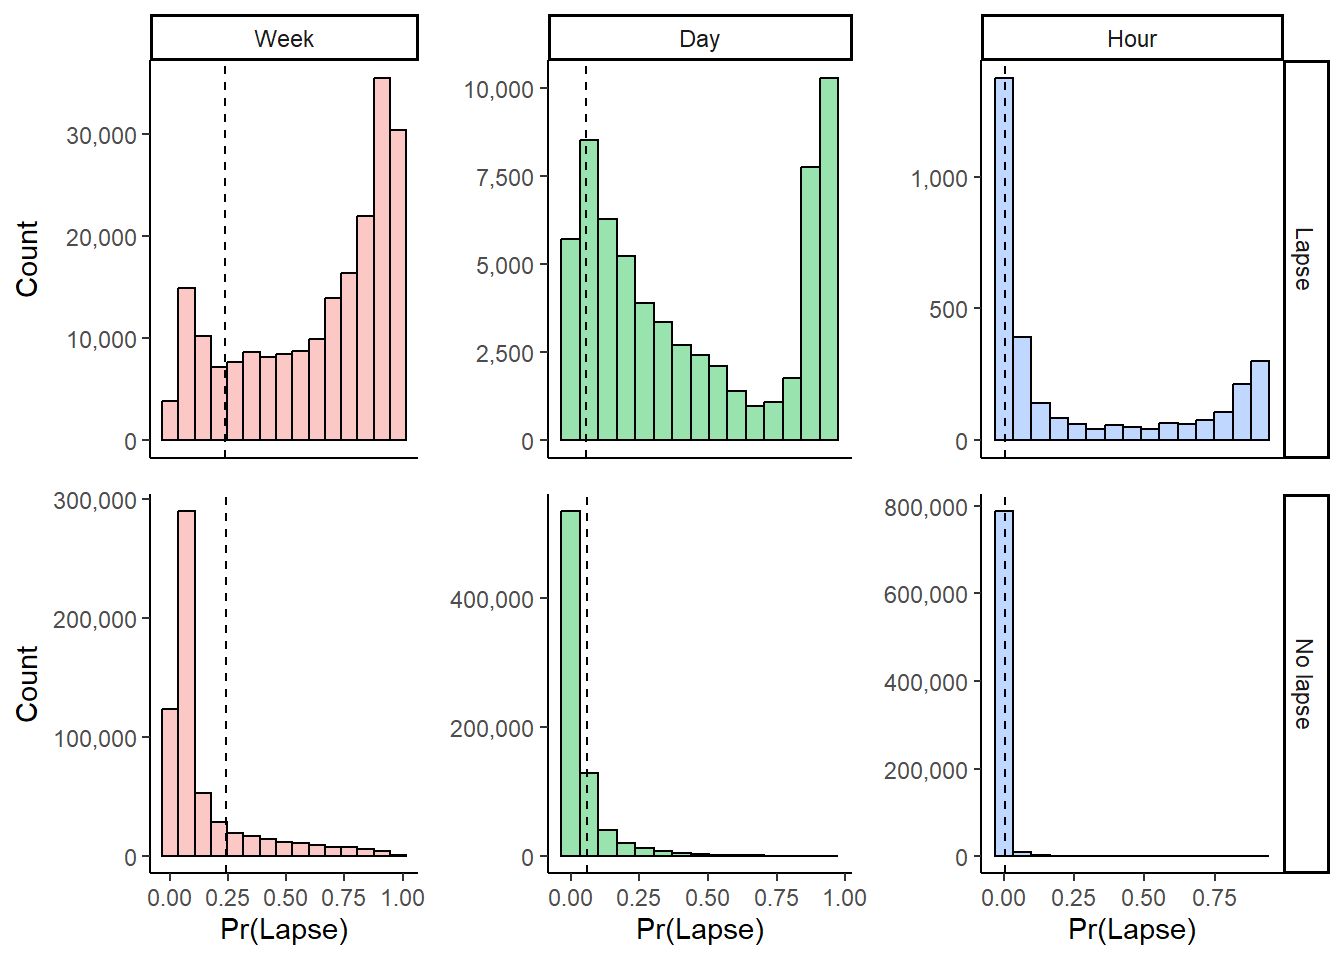

In [ ]:
#| fig-cap:
#|   - "Lapse probability predictions by model. The plots above depict predicted probabilities for all observations in the 30 test sets. The columns are organized by model (week, day, hour). The top row depicts estimated lapse probabilities for true lapses. The bottom row depicts estimated lapse probabilities for true no lapses. The dashed vertical lines represent the decision threshold for each model, determined using Youden's index."

plot_grid(fig_week, fig_day, fig_hour, nrow = 1, rel_widths = c(1, 1, 1.1))
